# Page Tables

Most programs don’t use all the virtual memory space, so we should do something about this

## First, a smaller Page Table

Instead of using one big Page Table, we use tables that is size of a page

Size of page: 12 bits offset $\implies$ Can be used to address = 2^12 = 4096 bytes (familiar?)

There are 2^9 = 512 entries **(PTE)**, 2^3 = **8 bytes each** (64 bits)

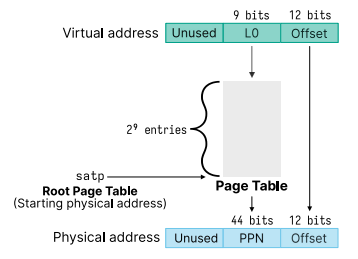

## SOLUTION: Then, cascade these small Page Tables

Multi-Level Page Tables Save Space for Sparse Allocations

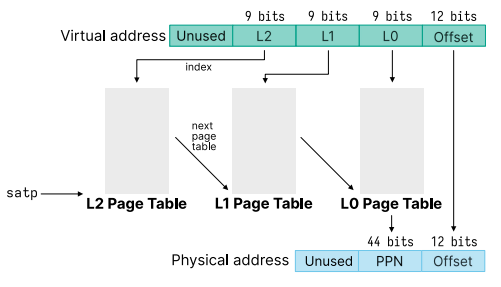

Output of L2 page table tells us **which L1 page table to use**  
9 bits is used to figure out which row (entry) in L1 page table, which is **which L0 page table to use**
.... Same with L0...

#### Difference:
- Before: 1GB to translate a single address
- Now: 3 page-sized page tables: 12KB

### Page Allocation Uses A Free List (Linked List)

Given physical pages, the operating system maintains a free list (linked list)

The unused pages themselves contain the next pointer in the free list. Physical memory gets initialized at boot

To allocate a page, you remove it from the free list  
To deallocate a page you add it back to the free list

EXAMPLE: Say we have Virtual address 0x3FFFF008, 2 levels of page tables L1 -> L0

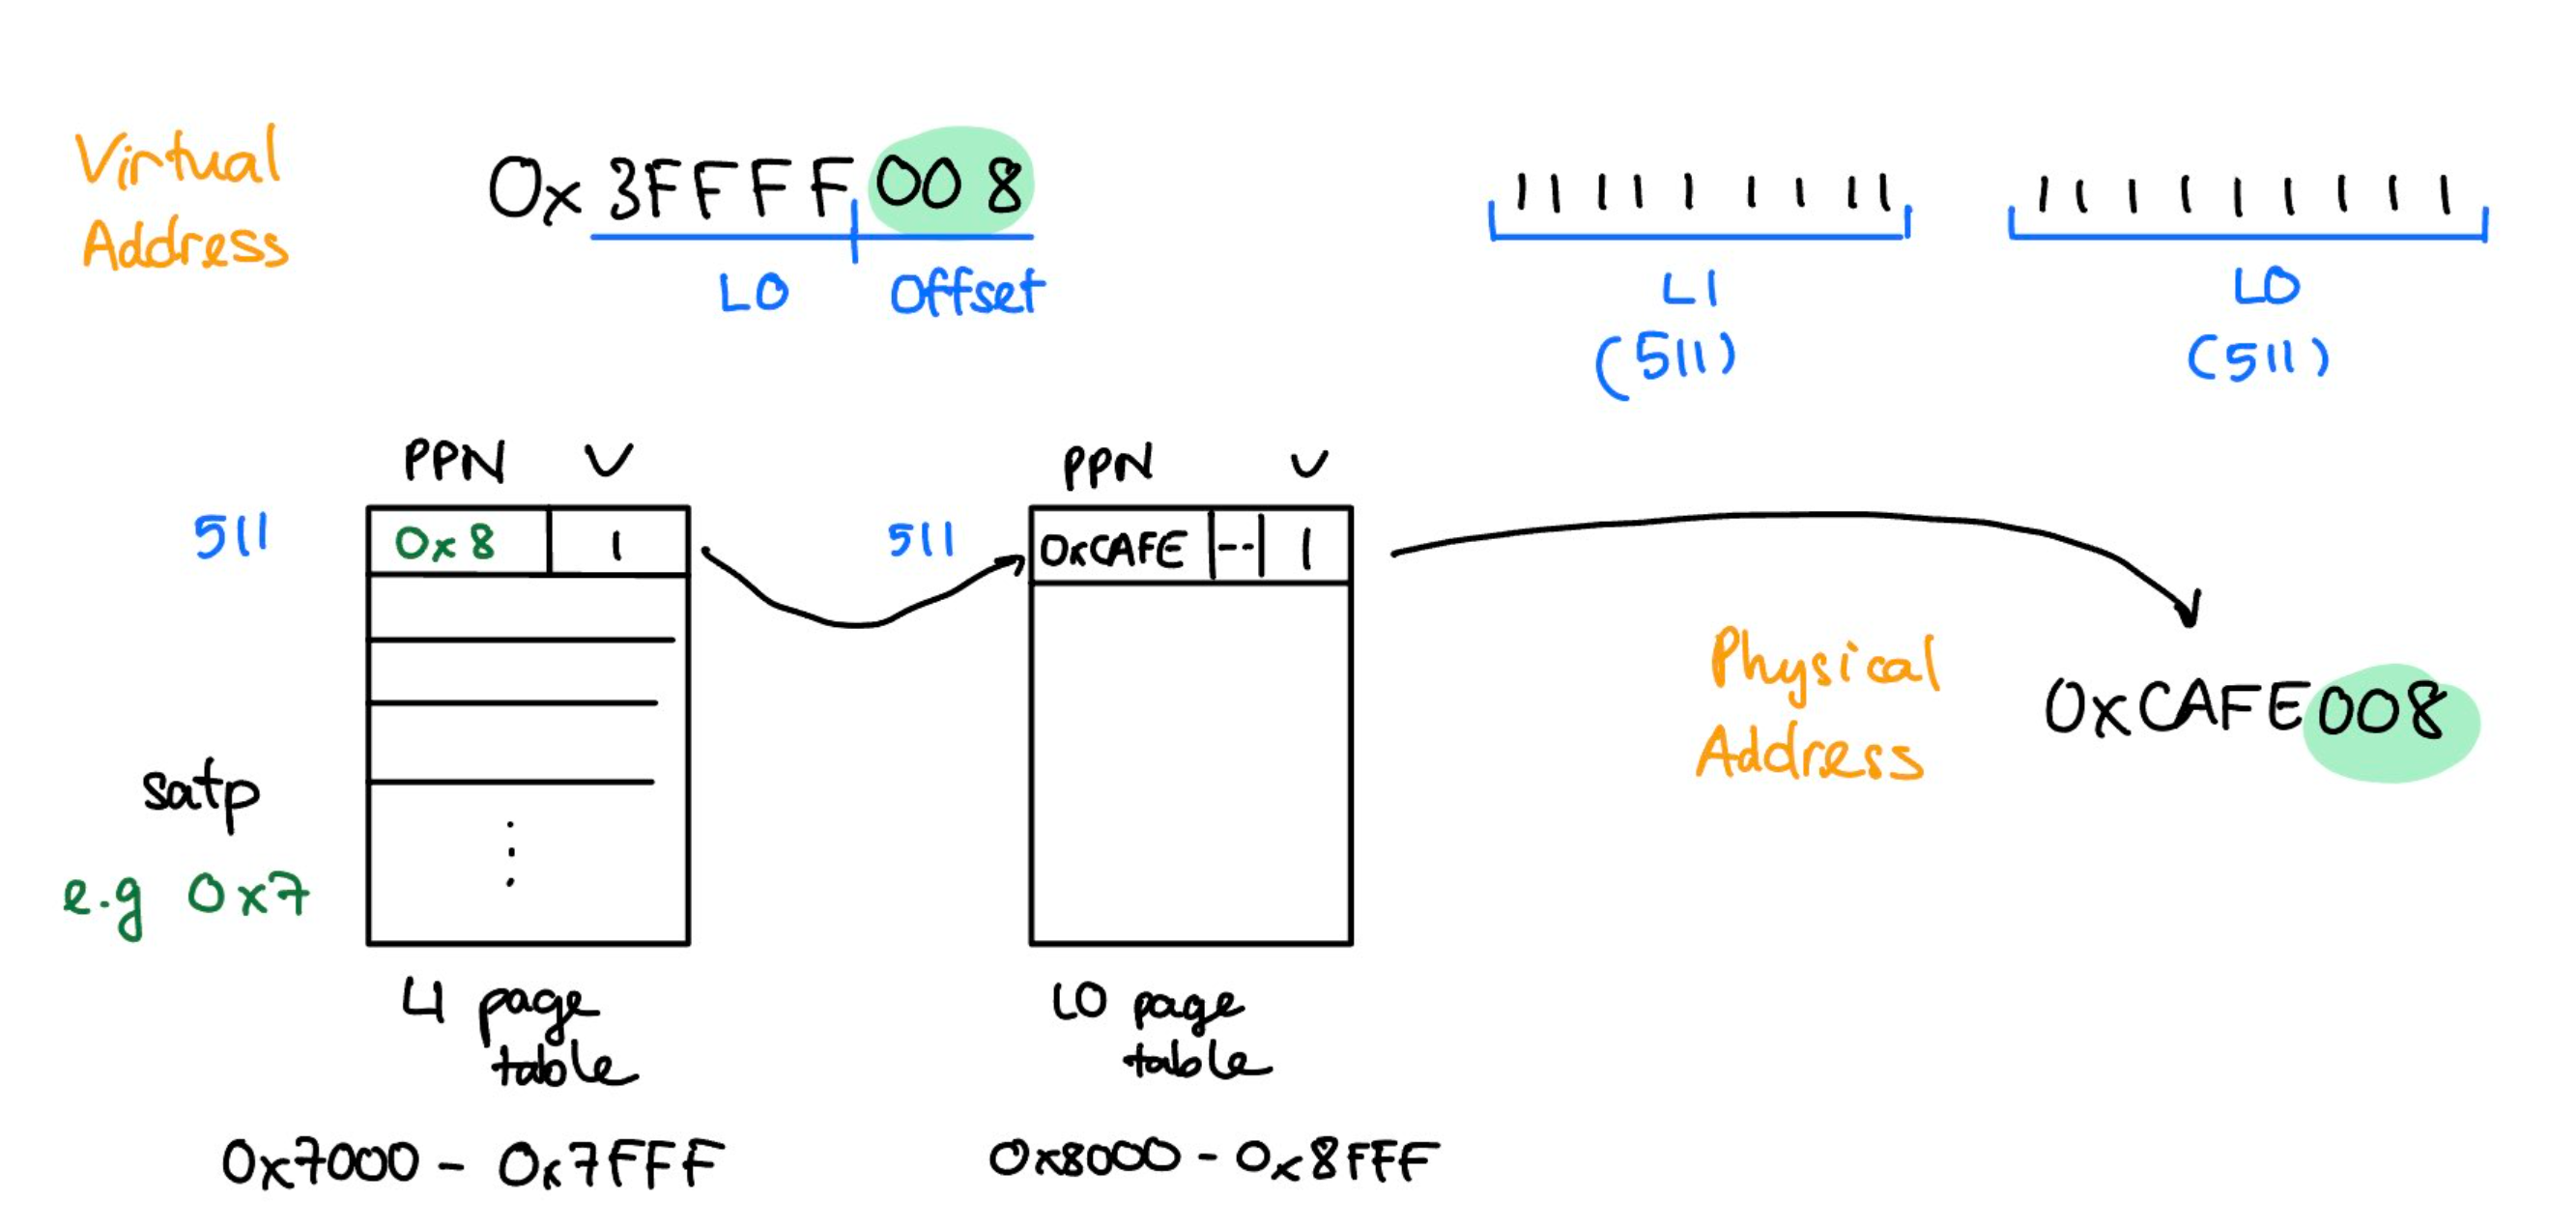

In [1]:
%%file run.c

#include <assert.h>
#include <errno.h>
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/mman.h>
#include <unistd.h>

#define PAGE_SIZE 4096

#define LEVELS 3
#define PTE_VALID (1 << 0)

static uint64_t* root_page_table = NULL;

static uint64_t* allocate_page_table() {
    void* page = mmap(NULL, PAGE_SIZE, PROT_READ|PROT_WRITE, MAP_ANONYMOUS|MAP_PRIVATE, -1, 0);
    if (page == MAP_FAILED) {
        int err = errno;
        perror("mmap");
        exit(err);
    }
    return page;
}

static void deallocate_page_table(void* page) {
    if (munmap(page, PAGE_SIZE) == -1) {
        int err = errno;
        perror("munmap");
        exit(err);
    }
}

static uint64_t mmu(uint64_t virtual_address) {
    uint64_t* page_table = root_page_table;
    uint64_t va = (uint64_t) virtual_address;
    for (int i = LEVELS - 1; i >= 0; --i) {
        uint8_t start_bit = 9 * i + 12;
        uint64_t mask = (uint64_t) 0x1FF << start_bit;
        uint16_t index = (mask & va) >> start_bit;

        uint64_t pte = page_table[index];
        if (!(pte & PTE_VALID)) {
            printf("0x%lX: page fault\n", va);
            return 0;
        }

        if (i != 0) {
            page_table = (uint64_t*) ((pte >> 10) << 12);
            continue;
        }

        uint64_t pa = ((pte & ~0x3FF) << 2) | (va & 0xFFF);
        printf("0x%lX: 0x%lX\n", va, pa);
        return pa;
    }
    __builtin_unreachable();
}


uint64_t pte_from_ppn(uint64_t ppn) {
    uint64_t pte = ppn << 10;
    pte |= PTE_VALID;
    return pte;
}

uint64_t pte_from_page_table(uint64_t* page_table) {
    return pte_from_ppn(((uint64_t) page_table) >> 12);
}

int main() {
    assert(sysconf(_SC_PAGE_SIZE) == PAGE_SIZE);

    uint64_t* l2_page_table_1 = allocate_page_table();

    root_page_table = l2_page_table_1;

    uint64_t* l1_page_table_1 = allocate_page_table();
    l2_page_table_1[0] = pte_from_page_table(l1_page_table_1);

    uint64_t* l0_page_table_1 = allocate_page_table();
    l1_page_table_1[5] = pte_from_page_table(l0_page_table_1);

    l0_page_table_1[188] = pte_from_ppn(0xCAFE);

    mmu(0xABCDEF);
    mmu(0x1ABCDEF);

    deallocate_page_table(root_page_table);
    root_page_table = NULL;

    return 0;
}


Overwriting run.c


The result will be:

    0xABCDEF: 0xCAFEDEF
    0x1ABCDEF: page fault

Why?
- DEF is offset (DEF)
- 9 bits L2, L1, L0 (ABC - 1010 1011 1100 - 000000000 000000101 010111100) $\implies$ Indexes 0, 5, 188 (we set up addresses for this)
